# Capítulo 8 - Introdução ao Policy Gradient - Reinforce


Você pode rodar este notebook no Colab ou localmente. Para abrir diretamente no Colab, basta clicar no link abaixo.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap08/cap08-main.ipynb) 

Para rodar localmente, primeiro, baixe todo o repositório do github: https://github.com/pablo-sampaio/rl_facil.

## 1. Configurações Iniciais

### Configurações Dependentes do Sistema

Rode a célula abaixo, mesmo sem estar no Colab.

In [1]:
import sys
from IPython.display import clear_output

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install gym==0.23.1  # also works with 0.25.2
    !pip install gym[box2d]
    !pip install tensorboard

    # para salvar videos
    !apt-get install -y ffmpeg xvfb x11-utils

    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

clear_output()

In [ ]:
if IN_COLAB:
    import os
    os.system("Xvfb :1 -screen 0 1400x900x24 &")
    os.environ['DISPLAY'] = ':1'

### Imports Principais

Importa algoritmos, ambientes e outros módulos.

In [33]:
import gym
import numpy as np
import optuna

from util.experiments import repeated_exec
from util.plot import plot_result, plot_multiple_results
from util.notebook import display_videos_from_path

from models_torch_pg import PolicyModelPG, test_policy
from reinforce import run_reinforce
from reinforce_advantage import run_reinforce_with_adv

## 2 - Rodando o Reinforce (Vanilla Policy Gradient)

In [17]:
ENV_NAME, rmax = "CartPole-v1", 500
#ENV_NAME, rmax = "Acrobot-v1", 0
#ENV_NAME, rmax = "LunarLander-v2", 150
#ENV_NAME, rmax = "MountainCar-v0", -20

EPISODES = 2000
GAMMA    = 0.95

env = gym.make(ENV_NAME)
inputs = env.observation_space.shape[0]
outputs = env.action_space.n
policy1 = PolicyModelPG(inputs, [128, 512], outputs, lr=0.0005)

returns1, policy1 = run_reinforce(env, EPISODES, 0.95, initial_policy=policy1, target_return=200.0)
clear_output()

print("Últimos episódios do treinamento: media =", np.mean(returns1[-20:]), ", desvio padrao =", np.std(returns1[-20:]))


Últimos episódios do treinamento: media = 9.4 , desvio padrao = 0.66332495807108


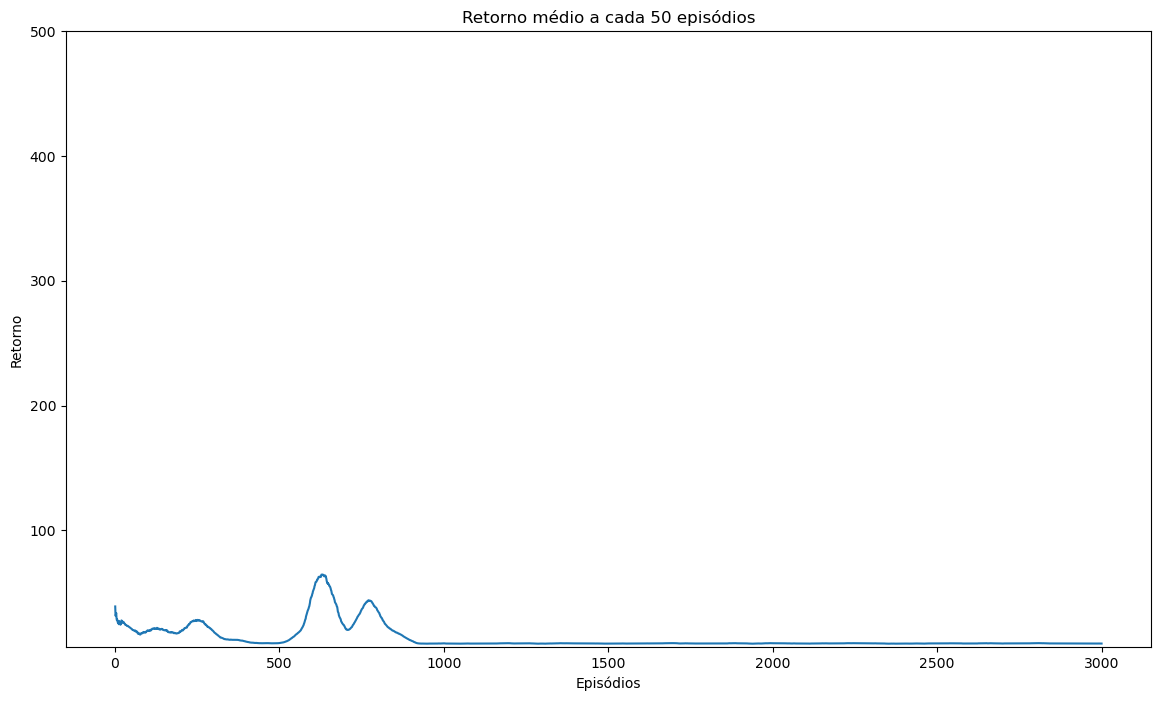

In [18]:
# Exibe um gráfico episódios x retornos (não descontados)
plot_result(returns1, rmax, window=50)

In [ ]:
# Roda alguns episódigos com o modelo e salva os vídeos em arquivos
env1 = gym.make(ENV_NAME)
video_env=gym.wrappers.RecordVideo(env1, "./vid-reinf", episode_trigger=(lambda ep : True))
test_policy(video_env, policy1, 0.0, 3, render=False)
video_env.close()

In [ ]:
display_videos_from_path('./vid-reinf')

## 3 - Rodando o Reinforce com Advantage

In [20]:
ENV_NAME, rmax = "CartPole-v1", 500
#ENV_NAME, rmax = "Acrobot-v1", 0
#ENV_NAME, rmax = "LunarLander-v2", 150
#ENV_NAME, rmax = "MountainCar-v0", -20

EPISODES = 2000
GAMMA    = 0.95

env = gym.make(ENV_NAME)
inputs = env.observation_space.shape[0]
outputs = env.action_space.n
policy2 = PolicyModelPG(inputs, [128, 512], outputs, lr=0.001)

returns2, policy2 = run_reinforce_with_adv(env, EPISODES, GAMMA, initial_policy=policy2, target_return=rmax-100)
clear_output()

print("Últimos episódios do treinamento: media =", np.mean(returns2[-20:]), ", desvio padrao =", np.std(returns2[-20:]))

Últimos episódios do treinamento: media = 480.95 , desvio padrao = 49.67441494371122


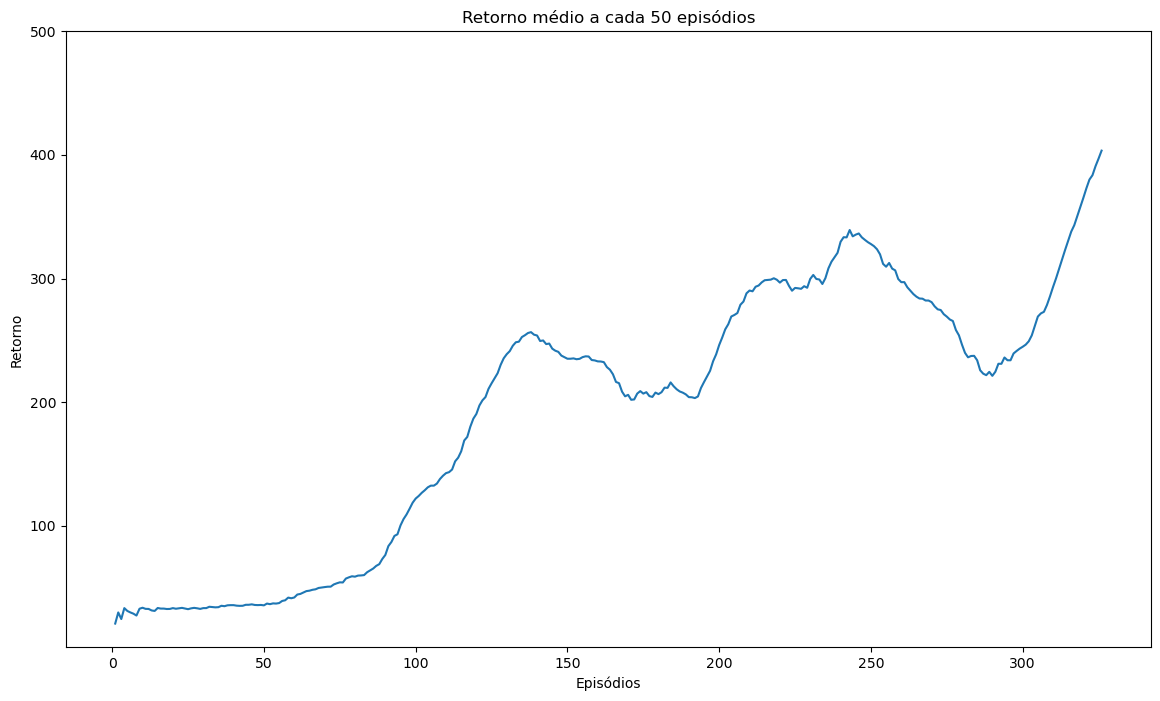

In [21]:
# Exibe um gráfico episódios x retornos (não descontados)
plot_result(returns2, rmax, window=50)

In [ ]:
# Faz alguns testes com o modelo de forma DETERMINÍSTICA e salva o vídeo em arquivo
#video = VideoRecorder(ENV, f"politica-reinf-advant-{ENV_NAME}.mp4")
#test_policy(ENV, policy2, True, 5, render=False, videorec=video)

In [ ]:
# Roda alguns episódigos com o modelo e salva os vídeos em arquivos
env2 = gym.make(ENV_NAME)
video_env=gym.wrappers.RecordVideo(env2, "./vid-reinf-adv", episode_trigger=(lambda ep : True))
test_policy(video_env, policy2, 0.0, 3, render=False)
video_env.close()

In [ ]:
display_videos_from_path('./vid-reinf-adv')

## 3 - Experimentos


### 3.1 Comparações Básicas


In [ ]:
AUTO_LOAD = True

In [24]:
env = gym.make("CartPole-v1")
NUM_EPISODES = 2000

results3 = []

results3.append( repeated_exec(3, f"Reinforce", run_reinforce, env, NUM_EPISODES, gamma=0.95, auto_load=AUTO_LOAD) )
clear_output()

results3.append( repeated_exec(3, f"Reinforce w/ Adv", run_reinforce_with_adv, env, NUM_EPISODES, gamma=0.95, auto_load=AUTO_LOAD) )
clear_output()

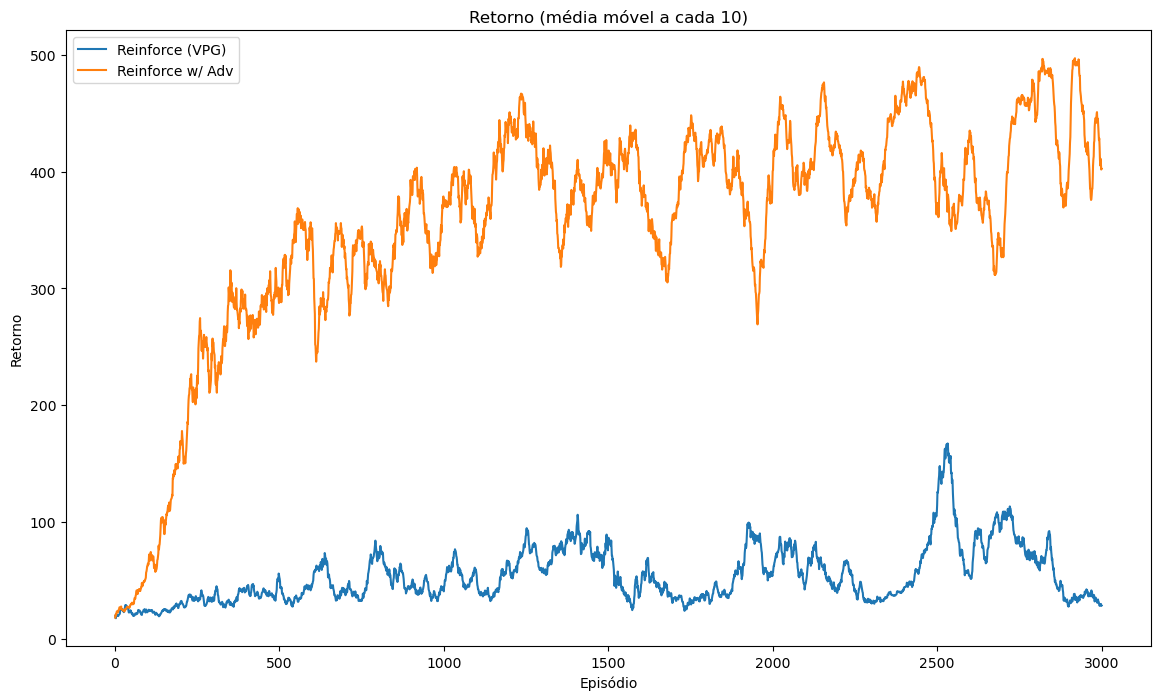

In [25]:
plot_multiple_results(results3, cumulative=False, x_log_scale=False)

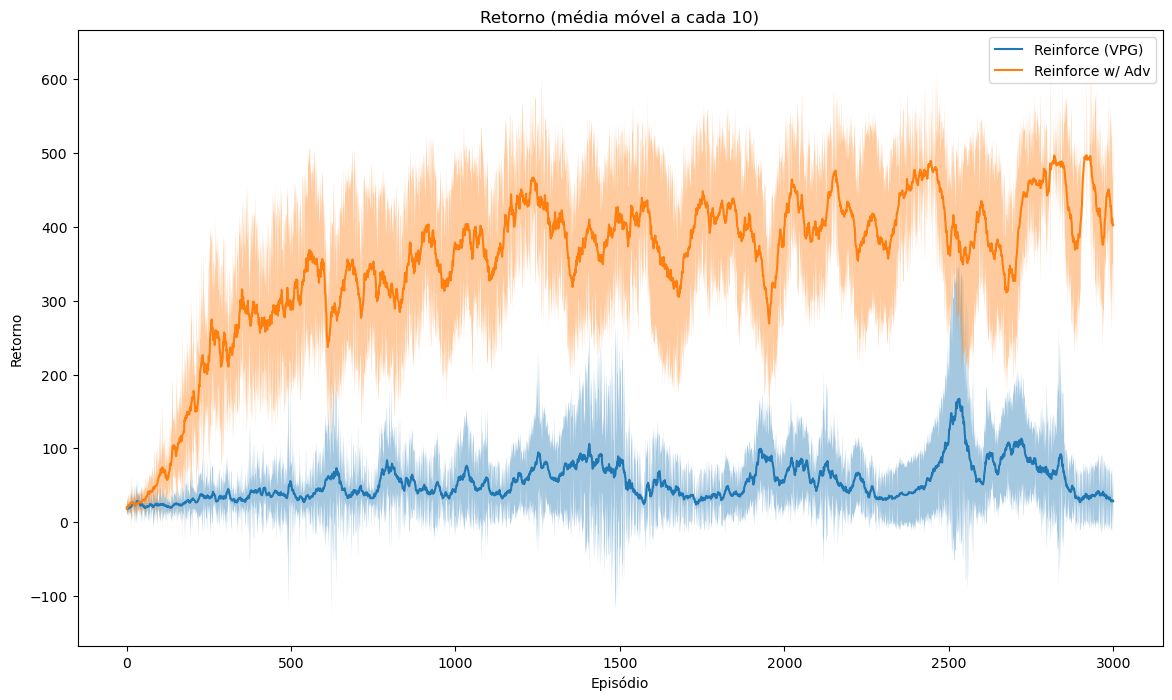

In [26]:
plot_multiple_results(results3, cumulative=False, plot_stddev=True)

### 3.2 Variando Parâmetros da Rede Neural

Vamos mostrar comparações variando apenas a quantidade de neurônios da (única) camada intermediária.

Você pode também variar todos os outros parâmetros da rede neural: quantidade de camadas e taxa de aprendizagem.

In [27]:
env = gym.make("CartPole-v1")

NUM_EPISODES = 1000

print("Observation Space - ", env.observation_space.shape)
print("Observation Space - shape", env.observation_space.shape)
print("Action Space - ", env.action_space)
print("Action Space - number of actions - ", env.action_space.n)

Observation Space -  (4,)
Observation Space - shape (4,)
Action Space -  Discrete(2)
Action Space - number of actions -  2


In [28]:
results4 = []

for hidden_layer_size in [16, 128]:
    policy_model = PolicyModelPG(env.observation_space.shape[0], [hidden_layer_size], env.action_space.n, lr=0.01)
    results4.append( repeated_exec(3, f"Reinforce (hnodes={hidden_layer_size})", run_reinforce, env, NUM_EPISODES, 0.99, policy_model, auto_load=AUTO_LOAD) )
    results4.append( repeated_exec(3, f"Reinforce Adv (hnodes={hidden_layer_size})", run_advantage_reinforce, env, NUM_EPISODES, 0.99, policy_model, auto_load=AUTO_LOAD) )
    clear_output()

In [31]:
results4

[('Reinforce (hnodes=16)',
  array([[ 16.,  20.,  18., ..., 500., 500.,  16.],
         [ 28.,  55.,  18., ..., 500., 500., 500.]])),
 ('Reinforce Adv (hnodes=16)',
  array([[ 11.,  26.,  15., ..., 500., 500., 500.],
         [ 16.,  62.,  53., ..., 500., 500., 500.]])),
 ('Reinforce (hnodes=128)',
  array([[19., 53., 13., ..., 32., 44., 49.],
         [39., 30., 34., ..., 10., 10., 10.]])),
 ('Reinforce Adv (hnodes=128)',
  array([[ 10.,  16.,  10., ..., 299., 327., 251.],
         [ 43.,  28.,  42., ...,  62.,  94.,  66.]]))]

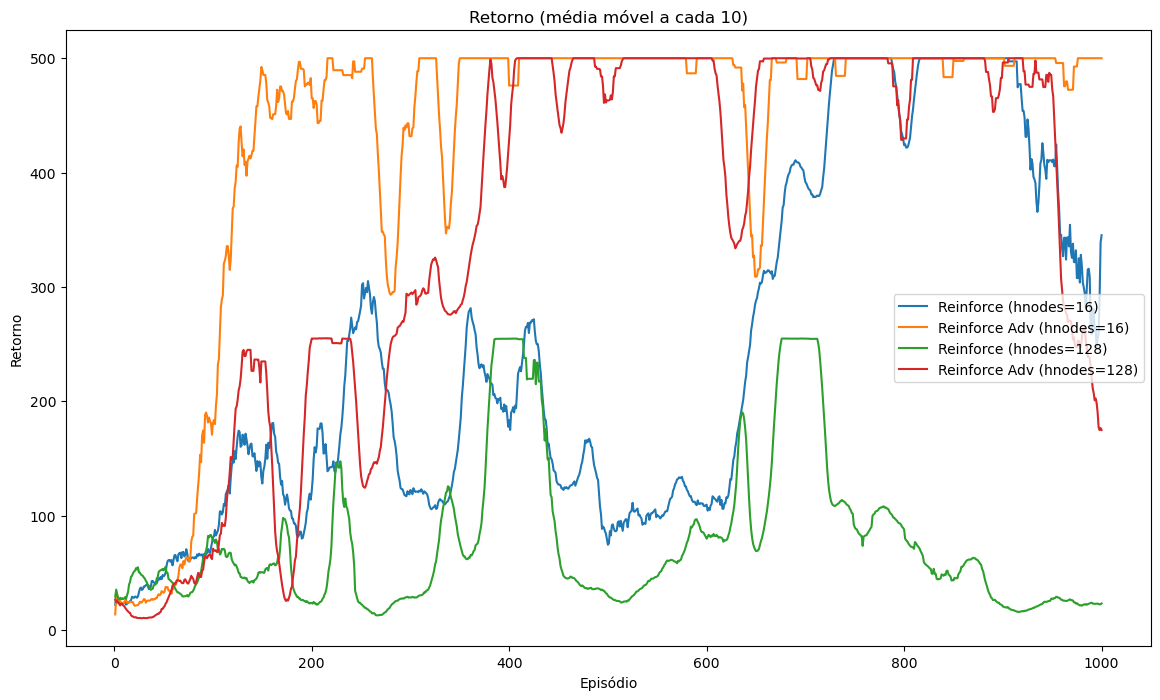

In [34]:
plot_multiple_results(results4, cumulative=False)